# Wstęp 

W dobie XXI wieku jesteśmy bombardowani infomacjami niemal z każdej strony. Mimo wielu, których jest dla nas ważnych, na których się znamy lub które nas dotyczą jest jeszcze więcej takich, z którymi nie mamy niemalże nic wspólnego. Z powodu tego nadmiaru informacji ludzie zatracili chęć do weryfikowania KAŻDEJ pozyskanej wiedzy. Jednakże, nie ma się co martwić, bo gdzie ludzki umysł napotyka problemy, to rozwiązaniem może stać się komputer. 

Zajmiemy się zbiorem danych zawierającym tytuły różnych tekstów wraz z ich treścią. Występują tu artykuły, reportaże jak idialogi, co oznacza, że tematyka jest mocno zróżnicowana. Oprócz tego dysponujemy kolumną 'Unnamed: 0', która identyfikuje poszczególne teksty. Zobaczmy co nas czeka w danym zbiorze danych. 

![ChessUrl](https://media.giphy.com/media/xUA7bfa2vnt2Yj8WQg/giphy.gif "chess")

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from textstat import flesch_reading_ease, gunning_fog
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.preprocessing import RobustScaler
import eli5
import spacy
nlp = spacy.load('en')

import warnings
warnings.filterwarnings('ignore')

Wczytajmy nasz zbiór danych i rzućmy okiem na kilka pierwszych wierszy

In [2]:
df = pd.read_csv('news/news.csv')
df['label'] = df['label'].astype('category')
df.head(10)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


Na wstępie warto zauważyć, że teksty są stosunkowo długie. Można skonfigurować ramki pandasa, aby wiersze wyświetlały całą swoją zawartość, ale są to treści na tyle rozwlekłe, że ramka stanie się mało przejrzysta. Warto na pierwszy rzut oka zauważyć, że teksty zawierają oznaczenia osób (pewnie tweety), daty, znaki specjalne jak i akapity. Rzućmy okiem jak prezentuje się kilka przykładowych tekstów.

In [3]:
print(df['text'][3])

— Kaydee King (@KaydeeKing) November 9, 2016 The lesson from tonight's Dem losses: Time for Democrats to start listening to the voters. Stop running the same establishment candidates. 
— People For Bernie (@People4Bernie) November 9, 2016 If Dems didn't want a tight race they shouldn't have worked against Bernie. 
— Walker Bragman (@WalkerBragman) November 9, 2016 
New York Times columnist Paul Krugman, who was one of Hillary Clinton’s most outspoken surrogates during the contentious Democratic primary, blamed Clinton’s poor performance on Green Party candidate Jill Stein, who has so far received a negligible number of votes nationally, saying Stein was the Ralph Nader of 2016 in preventing a Clinton victory. The account @BerniesTeachers threw Krugman’s analysis back in his face. Your candidate was the issue. Take responsibility. https://t.co/KHyOuUSrFS 
— Teachers for Bernie (@BerniesTeachers) November 9, 2016 
Ana Navarro, a Republican who recently endorsed Hillary Clinton, summed up

In [4]:
print(df['text'][10])

CEDAR RAPIDS, Iowa — “I had one of the most wonderful rallies of my entire career right here in 1992,” Bill Clinton said by way of opening to the crowd of more than 1,100 on Saturday night.

Two days before the Iowa caucuses, Cedar Rapids tried to deliver that same old feeling to his wife, Hillary Clinton.

In the crowd, one woman held a sign that said “227 years of men. It’s HER turn!" Some carried signs and books. Others had traveled from as far as Missouri. They had waited hours, even after the fire marshal told them there was no more room inside the high school gymnasium.

The restive crowd chanted slogans and buzzed with anticipation until finally Bill, Hillary and Chelsea Clinton all appeared on stage hand-in-hand, an hour behind schedule. As they roared, Hillary Clinton beamed.

It has been a long slog in Iowa for the Clinton campaign, which has struggled mightily to shake the label that its supporters can’t muster the enthusiasm of its rival’s backers. As the caucuses near, and

In [5]:
print(df['text'][20])

With little fanfare this fall, the New York developer who had planned to build an Islamic community center north of the World Trade Center announced that he would instead use the site for a 70-story tower of luxury condos.

Those who had rallied in opposition to the building because of its religious affiliation back in 2010 were exultant. “The importance of the defeat of the Ground Zero Mosque cannot be overstated,” Pamela Geller, president of the American Freedom Defense Initiative, wrote on the website Breitbart in September. “The Ground Zero Mosque became a watershed issue in our effort to raise awareness of and ultimately halt and roll back the advance of Islamic law and Islamic supremacism in America.”

It’s all well and good that so many Republicans have condemned Donald Trump’s reprehensible call for “a total and complete shutdown of Muslims entering the United States.” House Speaker Paul D. Ryan (Wis.) was particularly forceful, calling proper attention to the “many Muslims ser

# EDA

Zawsze warto przejrzeć kilka przykładowych tekstów. Kto wie? Może będą w stanie naprowadzić na jakiś trop, coś co ułatwi algorytmowi klasyfikacje.

Sprawdźmy, co więcej powiedzą nam statystyki numeryczne uzyskane z poszczególnych kolumn.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null category
dtypes: category(1), int64(1), object(2)
memory usage: 154.9+ KB


In [4]:
df.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [5]:
len(df['Unnamed: 0'].unique())

6335

In [6]:
df.describe(include=['O', 'category'])

,title,text,label
count,6335,6335,6335
unique,6256,6060,2
top,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,5,58,3171


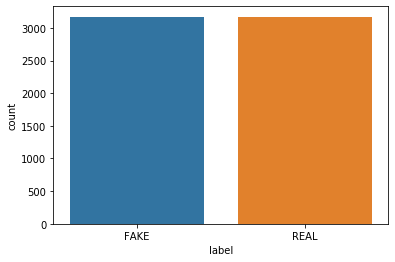

In [7]:
sns.countplot(x='label', data=df);

In [8]:
df['title'].value_counts()[:5]

OnPolitics | 's politics blog                                                                         5
Get Ready For Civil Unrest: Survey Finds That Most Americans Are Concerned About Election Violence    3
Michael Moore Owes Me $4.99                                                                           3
Hillary’s “Big Tent” is Obama’s “Grand Bargain” on Steroids                                           3
Senate GOP prepared to replace Obamacare subsidies                                                    2
Name: title, dtype: int64

In [9]:
df[df['title']=="OnPolitics | 's politics blog"]

,Unnamed: 0,title,text,label
664,1951,OnPolitics | 's politics blog,What you need to know about the election recou...,REAL
1643,4337,OnPolitics | 's politics blog,Who has Trump picked for his Cabinet so far?\n...,REAL
2072,1672,OnPolitics | 's politics blog,Who has Trump appointed to his cabinet so far?...,REAL
3301,1762,OnPolitics | 's politics blog,Who has Trump appointed to his cabinet so far?...,REAL
5127,2271,OnPolitics | 's politics blog,Who has Trump appointed to his cabinet so far?...,REAL


In [10]:
df['text'].value_counts()[:3]

Killing Obama administration rules, dismantling Obamacare and pushing through tax reform are on the early to-do list.    58
                                                                                                                         36
A verdict in 2017 could have sweeping consequences for tech startups.                                                    23
Name: text, dtype: int64

Z kilku powyższych kroków można wysnuć następujące wnioski:
- Mamy 6335 obserwacji, z czego jedną kolumne numeryczną, 2 tekstowe i jedną kategoryczną.
- Identyfikatory z kolumny numerycznej są unikalne i pochodzą z przedziału od 2 do 10557. Czyli rozstęp jest większy niż nasza liczba rekordów. Ciekawe jak ta informacja zostanie zinterpretowana przez model.
- Nasz zbiór danych jest dobrze zbalansowany, mamy bardzo podobną ilość informacji prawdziwych jak i fake news'ów. Oszczędza nam to problemów z samplowaniem zbioru. 
- Co zaskakujące jak na tak mały zbiór danych pojawiły się tytuły, które się powtarzają. Zawartość tekstu przy nich jednak nieznacznie się różni, lecz wygląda na to, że tematyka nie ulega zmianie. Najwidoczniej wiadomość musiała być dość popularna lub osoba tworząca zbiór danych mogła popełnić błąd. W każdym razie nie napotykamy dwuznaczności, gdyż wszystkie próbki są tak samo skategoryzowane jako prawdziwe.
- Bardzo ważnym spostrzeżeniem jest występowanie wartości zerowych, w postaci pustych tekstów w kolumnie 'text'. Mogłyby narobić niemałe problemy przy tworzeniu dodatkowych cech dlatego na wstępie warto się nimi jakoś zająć.

#  Preprocessing

Usuniemy na początku wartości brakujące zastępując je stringiem a. Decyduje się na takie rozwiązanie, ponieważ będę w przyszłości dążył do utworzenia cech numerycznych bazusjąc na stringach, natomiast wstawienie samej spacji generowałoby w przyszłości powstatnie wartości NaN. Przygotujmy nasze dane dzieląc je na zbiór testowy i treningowy. Jest to bardzo ważny krok, który powie nam w jaki sposób nasz model zachowa się wobec danych, z którymi jeszcze nie miał styczności. 

In [66]:
df['text'] = df['text'].str.strip()
df['text'][df['text']==''] = 'a'
df['text'].value_counts()[:3]

Killing Obama administration rules, dismantling Obamacare and pushing through tax reform are on the early to-do list.    58
0                                                                                                                        36
A verdict in 2017 could have sweeping consequences for tech startups.                                                    23
Name: text, dtype: int64

In [67]:
X_train_try, X_test_try, y_train_try, y_test_try = train_test_split(df['text'], df['label'], random_state=42)

Zanim jeszcze nasze palce zaczną płonąć od tworzenia cech z naszych danych, rzućmy okiem jak tak naprawdę zachowa się przykładowy model wobec danych po ich krótkiej obróbce. Otrzymamy wtedy obraz na czym tak naprawdę stoimy i ile jeszcze pracy przed nami.

Przykładowo wykorzystamy Tfidf (ang. Tf - term frequency, idf - inverse document frequency). Jest to operacja wykorzystująca częstotliwość słów w tekście, przez która przydziela odpowiednim słowom tagi. Przypisywana jest tym większa waga im częściej wyraz występuje w jak najmniejszej ilości artykułów. Oznacza to, że słowa z wysoką wagą należą do języka specjalistycznego występującego w tekstach o małej popularności. Odwrotnie się ma sprawa ze słowami o małej wadze. Występują rzadko w tekście, natomiast pojawiają się niemal w każdej próbce. Z matematycznego punktu widzenia opisuje to równanie:

$$w_{i,j} = tf_{i,j} \cdot \log{(\frac{N}{df_i})}$$

$w_{i,j}$ - waga $i$-tego słowa w $j$-tym dokumencie <br>
$tf_{i,j}$- liczba pojawień się słowa $i$ w $j$-tym dokumencie<br>
$df_i$ - liczba dokumentów zawierających słowo $i$<br>
$N$ - liczba dokumentów<br>
Skorzystamy z wbudowanej funkcji modelu sklearn TfidfVectorizer, która na wstępie konwertuje wszystkie wyrazy tekstu na małe litery. Natomiast flaga stop_words usuwa wyrażenia stopujące, tzw. łączniki, nie zaś słowa kluczowe.<br>
O ile operacja jest łatwa w implemetacji to znaczącą wadą metody jest wielkość macierzy, która w jej wyniku powstaje. Kolejnym problemem są słowa, które występują w zbiorze testowym, lecz nie pojawiają się w procesie uczenia. Z tego powodu tracimy część informacji, która mogłaby mieć kluczowe znaczenie dla wyniku predykcji modelu. Zobaczmy jaki wynik uzyskamy po przekształceniu kolumny 'text' funkcją Tfidfvectorizer

In [68]:
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
X_train_tf_try = vectorizer.fit_transform(X_train_try)
X_test_tf_try = vectorizer.transform(X_test_try)
X_train_tf_try.shape

(4751, 62680)

Jak widzimy uzyskaliśmy nieco powyżej 62 tysięcy cech i to wyłącznie z przekształcenia jednej kolumny. Ta liczba urosłaby do jeszcze większej gdybyśmy przekształcili kolumne zawierającą tytuły dokumentów. Wykorzystajmy model regresji logistycznej do naszego zagadnienia klasyfikacji.

In [69]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tf_try, y_train_try)
lr.score(X_test_tf_try, y_test_try)

0.9204545454545454

Wynik jest zadziwiająco wysoki jak na tak proste przygotowanie do ewaluacji- accuracy na poziomie 92%. Zobaczmy jak zachowa się nasz model po tunowaniu i wykorzystaniu sprawdzianu krzyżowego. 

In [143]:
param_dict1 = {'penalty' : ['l1', 'l2'],
               'C' : np.logspace(-10, 10, 40),
               'solver' : ['liblinear']},

model1 = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_dict1, cv = 5, verbose=True, n_jobs=-1)
model1.fit(X_train_tf_try, y_train_try)
model1.score(X_test_tf_try, y_test_try)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   35.0s finished


0.9393939393939394

In [144]:
model1.best_params_

{'C': 19.144819761699537, 'penalty': 'l2', 'solver': 'liblinear'}

Tym oto sposobem otrzymujemy bardzo wysoki wynik na poziomie dokładności 94%. Niektórych ten wynik mógłby już zadowolić, ale sprawdźmy czy jesteśmy w stanie wycisnąć coś więcej z naszych danych. Może nawet poprzez dodanie odpowiednich cech będziemy mogli zoptymalizować nasze rozwiązanie. 

Klasycznie zaczniemy od dodania kolumn zawierających podstawowe cechy numeryczne takie jak długość tekstu, średnia długość słowa w tekście itd. Ponadto wyliczmy współcznniki Flescha i Gunninga, mówiące o tym jak skomplikowany dany tekst jest.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:3], df['label'], random_state=42)

In [73]:
# length of text
X_train['text_len'] = X_train['text'].apply(len)
X_test['text_len'] = X_test['text'].apply(len)
X_train['title_len'] = X_train['title'].apply(len)
X_test['title_len'] = X_test['title'].apply(len)

In [74]:
# Amount of words
X_train['title_word_count']  = X_train['title'].str.split().apply(len)
X_test['title_word_count']  = X_test['title'].str.split().apply(len)
X_train['text_word_count']  = X_train['text'].str.split().apply(len)
X_test['text_word_count']  = X_test['text'].str.split().apply(len)

In [75]:
#Amount of unique words
X_train['title_u_word_count']  = X_train['title'].str.split().apply(lambda x: len(set(x)))
X_test['title_u_word_count']  = X_test['title'].str.split().apply(lambda x: len(set(x)))
X_train['text_u_word_count']  = X_train['text'].str.split().apply(lambda x: len(set(x)))
X_test['text_u_word_count']  = X_test['text'].str.split().apply(lambda x: len(set(x)))

In [76]:
# Average length of word
def avg_len_word(df):
    list_of_length = [len(word) for word in df]
    return np.mean(list_of_length)

X_train['title_avg_len_word'] = X_train['title'].str.split().apply(avg_len_word)
X_test['title_avg_len_word'] = X_test['title'].str.split().apply(avg_len_word)
X_train['text_avg_len_word'] = X_train['text'].str.split().apply(avg_len_word)
X_test['text_avg_len_word'] = X_test['text'].str.split().apply(avg_len_word)

In [77]:
# Flesch reading ease score and Gunning fog index
def reading_ease_score(df, score):
    dict_of_scores = Textatistic(df).scores
    return dict_of_scores[score]

X_train['title_flesch_score'] = X_train['title'].apply(lambda row: flesch_reading_ease(row))
X_test['title_flesch_score'] = X_test['title'].apply(lambda row: flesch_reading_ease(row))
X_train['text_flesch_score'] = X_train['text'].apply(lambda row: flesch_reading_ease(row))
X_test['text_flesch_score'] = X_test['text'].apply(lambda row: flesch_reading_ease(row))

X_train['title_gunning_score'] = X_train['title'].apply(lambda row: gunning_fog(row))
X_test['title_gunning_score'] = X_test['title'].apply(lambda row: gunning_fog(row))
X_train['text_gunning_score'] = X_train['text'].apply(lambda row: gunning_fog(row))
X_test['text_gunning_score'] = X_test['text'].apply(lambda row: gunning_fog(row))

Trenując model często ważne jest dla nas, aby nasze kolumny były niezależne, albo chociażby nieskorelowane ze sobą. Zobaczmy na macierzy korelacji jak nasze kolumny zależą od siebie.

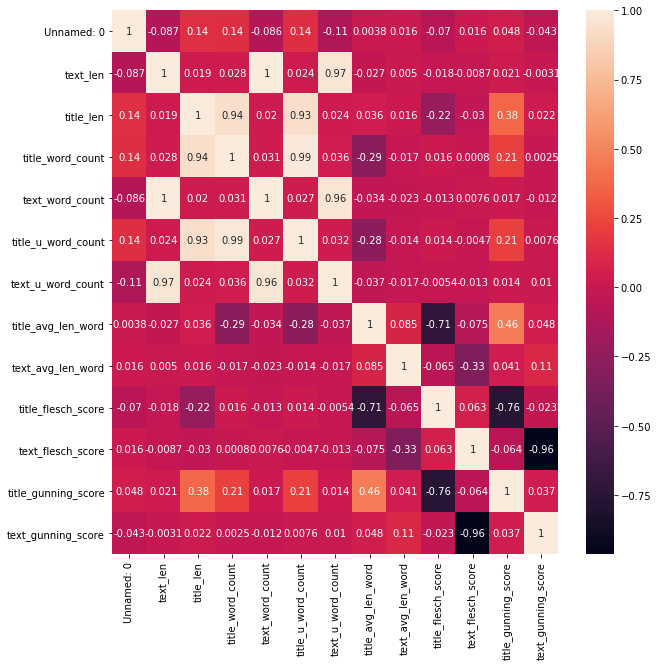

In [78]:
corr = X_train.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, ax=ax);

Widzimy, że w ewidentny sposób kolumny z długością zarówno tekstu jak i tytułów są skorelowane z odpowiadającymi im kolumnami z ilością słów. Poza tym, współczynnik Flescha jest liniowo zależny od współczynnika Gunninga. Pozbędziemy się po jednej z poszczególnych kolumn, żeby nie pogorszyły wyników naszego modelu.

In [79]:
drop_columns = ['title_word_count', 'text_word_count', 'text_u_word_count', 'title_u_word_count', 'text_flesch_score',
                'title_flesch_score']

In [80]:
X_train = X_train.drop(columns=drop_columns)
X_test = X_test.drop(columns=drop_columns)

Od razu lepiej. Można by się jeszcze zastanowić nad zależnością pomiędzy średnią długością słowa, a współczynnikiem Gunninga, ale podjąłem decyzję, że obie zostaną.

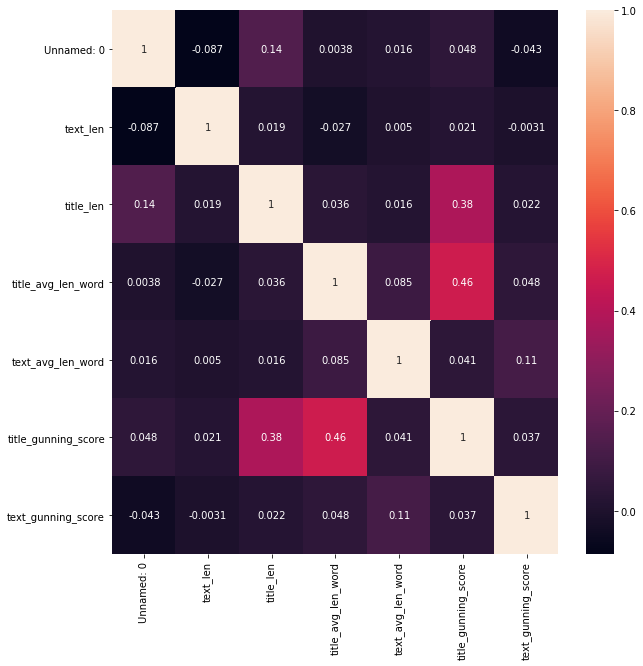

In [133]:
corr = X_train.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, ax=ax);

Nie wykorzystując tym razem algorytmu TF-IDF, lecz bazując na cechach do tej pory posiadanych lub utworzonych zobaczmy jak zachowa się model lasów losowych i regresji logistycznej. Wielkim zdziwieniem był dla mnie fakt, że jesteśmy w stanie ocenić czy dany tekst jest fake news'em czy nie ze 100% dokładnością, bazując tylko na 6 cechach.

In [ ]:
param_dict2 = {'C' : np.logspace(-10, 10, 40)}

model2 = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_dict2, cv = 5, n_jobs=-1)
model2.fit(X_train.loc[:, ~X_train.columns.isin(['text', 'title'])], y_train)
model2.score(X_test.loc[:, ~X_test.columns.isin(['text', 'title'])], y_test)

In [85]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)

rf.fit(X_train.loc[:, ~X_train.columns.isin(['text', 'title'])], y_train)
rf.score(X_test.loc[:, ~X_test.columns.isin(['text', 'title'])], y_test)

1.0

In [86]:
feature_list = ['Unnamed: 0', 'text_len', 'title_len',
       'title_avg_len_word', 'text_avg_len_word', 'title_gunning_score',
       'text_gunning_score']

In [87]:
eli5.show_weights(rf, feature_names=feature_list)

Weight,Feature
0.8895 ± 0.2009,Unnamed: 0
0.0517 ± 0.1033,text_len
0.0222 ± 0.0521,text_gunning_score
0.0174 ± 0.0393,title_len
0.0117 ± 0.0306,text_avg_len_word
0.0038 ± 0.0117,title_avg_len_word
0.0037 ± 0.0117,title_gunning_score


Jak widać, tak spektakularny wynik zawdzięczamy tajemniczej kolumnie 'Unnamed: 0'. Źródło danych nie podaje szczegółowych informacji odnośnie pochodzenia tej cechy. Skoro jednak została ona dostarczona, to nie ma powodu, dla którego nie powinno się z niej skorzystać. 

Rozpatrzmy jednak jeszcze przypadek, gdy nie jesteśmy w tak dobrej sytuacji, a jedynym co jest do nas dostarczone, jest surowy tekst.

# Ewaluacja bez wykorzystania Unnamed: 0 

Jak widzimy bez naszego tajemniczego identyfikatora wyniki znacząco się pogorszyły. Ciekawi mnie co takiego musiał w sobie kryć. Pamiętamy oczywiście, że była to cechy unikalna dla każdego rekordu.

In [90]:
model2 = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_dict2, cv = 5, n_jobs=-1)
model2.fit(X_train.loc[:, ~X_train.columns.isin(['text', 'title', 'Unnamed: 0'])], y_train)
model2.score(X_test.loc[:, ~X_test.columns.isin(['text', 'title', 'Unnamed: 0'])], y_test)

0.6553030303030303

In [91]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train.loc[:, ~X_train.columns.isin(['text', 'title', 'Unnamed: 0'])], y_train)
rf.score(X_test.loc[:, ~X_test.columns.isin(['text', 'title', 'Unnamed: 0'])], y_test)

0.7430555555555556

Na poniższym wykresie zauważamy, że w naszych danych mamy doczynienia z wartościami odstającymi. Warto rozpatrzyć dwa podejścia:
- Przeskalowanie danych za pomocą IQR
- Zbadanie wartości odstających i zdecydowanie czy nie lepszym rozwiązaniem byłoby je usunąć

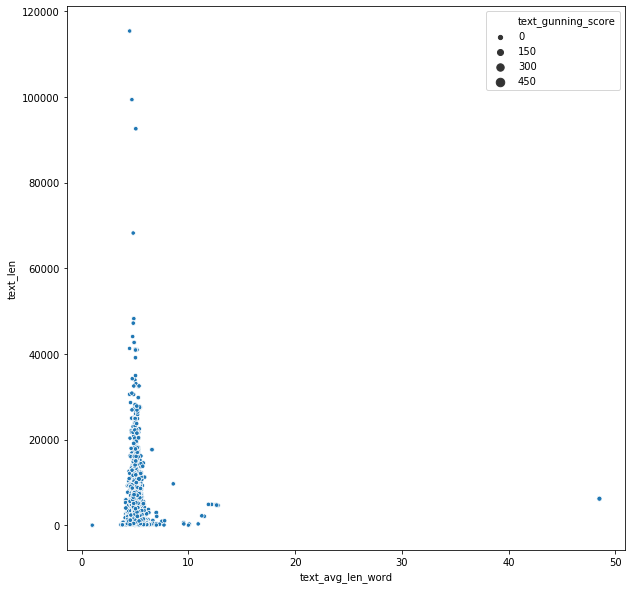

In [93]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=X_train, y="text_len", x="text_avg_len_word", size='text_gunning_score', ax=ax);

###  Przeskalowanie danych

Niestety, przeskalowanie danych nie poprawiło znacząco sytuacji...

In [134]:
m_train = X_train.loc[:, ~X_train.columns.isin(['text', 'title', 'Unnamed: 0'])]
m_test =X_test.loc[:, ~X_test.columns.isin(['text', 'title', 'Unnamed: 0'])]

m_train_scalled = transformer.fit_transform(m_train)
m_test_scalled = transformer.transform(m_test)

model3 = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_dict2, cv = 5, n_jobs=-1)
model3.fit(m_train_scalled, y_train)
model3.score(m_test_scalled, y_test)

0.6426767676767676

###  Zlokalizowanie wartości odstających

Z naszego scatterplota można zauwazyć, że wartości odstające występują, gdy np. średnia długość słowa jest dłuższa niż 10. Przyjrzyjmy się owym rekordom.

In [138]:
m_train[m_train.text_avg_len_word > 10].index

Int64Index([229, 3058, 5716, 4983, 2767, 1627, 3984, 5035, 1165, 2060, 4107], dtype='int64')

In [139]:
X_train.text[3058]

'We Are Change \nIn this video Luke Rudkowski covers more geopolitical moves and how the recent presidential election with Hillary Clinton is making the situation with Putin worse. The situation between these two super global powers is intensifying and becoming dangerous for both nations. As wikileaks keeps releasing more information the more pressure the DNC is putting against Russia instead of taking responsibility. For more invest in us on https://www.patreon.com/wearechange \nSources\nhttps://www.youtube.com/watch?v=4mt_z… \nhttp://www.cnn.com/videos/politics/20… \nhttp://www.inquisitr.com/3225440/hill… \nhttp://wearechange.org/putins-russian… \nhttp://www.mirror.co.uk/tech/russia-t… \nhttp://www.mintpressnews.com/wife-fbi… \nhttp://www.breitbart.com/2016-preside… \nhttps://twitter.com/wikileaks/status/… \nhttps://twitter.com/Lukewearechange/s… \nhttp://www.reuters.com/article/us-usa… \nhttp://www.mirror.co.uk/news/world-ne… \nhttp://www.zerohedge.com/news/2016-10… \nhttps://www.rt

In [140]:
X_train.text[2060]

"How to contact WikiLeaks? What is Tor? Tips for Sources After Submitting \nThis key's fingerprint is A04C 5E09 ED02 B328 03EB 6116 93ED 732E 9231 8DBA BEGIN PGP PUBLIC KEY BLOCK mQQNBFUoCGgBIADFLp+QonWyK8L6SPsNrnhwgfCxCk6OUHRIHReAsgAUXegpfg0b rsoHbeI5W9s5to/MUGwULHj59M6AvT+DS5rmrThgrND8Dt0dO+XW88bmTXHsFg9K jgf1wUpTLq73iWnSBo1m1Z14BmvkROG6M7+vQneCXBFOyFZxWdUSQ15vdzjr4yPR oMZjxCIFxe+QL+pNpkXd/St2b6UxiKB9HT9CXaezXrjbRgIzCeV6a5TFfcnhncpO ve59rGK3/az7cmjd6cOFo1Iw0J63TGBxDmDTZ0H3ecQvwDnzQSbgepiqbx4VoNmH OxpInVNv3AAluIJqN7RbPeWrkohh3EQ1j+lnYGMhBktX0gAyyYSrkAEKmaP6Kk4j /ZNkniw5iqMBY+v/yKW4LCmtLfe32kYs5OdreUpSv5zWvgL9sZ+4962YNKtnaBK3 1hztlJ+xwhqalOCeUYgc0Clbkw+sgqFVnmw5lP4/fQNGxqCO7Tdy6pswmBZlOkmH XXfti6hasVCjT1MhemI7KwOmz/KzZqRlzgg5ibCzftt2GBcV3a1+i357YB5/3wXE j0vkd+SzFioqdq5Ppr+//IK3WX0jzWS3N5Lxw31q8fqfWZyKJPFbAvHlJ5ez7wKA 1iS9krDfnysv0BUHf8elizydmsrPWN944Flw1tOFjW46j4uAxSbRBp284wiFmV8N TeQjBI8Ku8NtRDleriV3djATCg2SSNsDhNxSlOnPTM5U1bmh+Ehk8eHE3hgn9lRp 2kkpwafD9pXaqNWJMpD4Amk60L3N+yUrbFWERwncr

I wszystko jasne. Teksty zawierały niezwykle długie linki, które znacząco zawyżały statystyki. Myślę, że zachowywanie ich nie poprawi działania modelu. Analogiczna sytuacja dotyczy tekstów, których długość wynosi ponad 40000 znaków. Dlatego po prostu usuniemy te rekordt. Pamiętając, że musimy usunąć odpowiednie im targety.

In [141]:
indexes1 = m_train[m_train.text_len > 40000].index
indexes2 = m_train[m_train.text_avg_len_word > 10].index
indexes = np.unique(indexes1.append(indexes2))
m_train = m_train.drop(indexes, axis=0)
m_y_train = y_train.drop(indexes, axis=0)

Wykres prezentuje się już dużo lepiej, przypomina wręcz gęstość rozkłądu normalnego :D

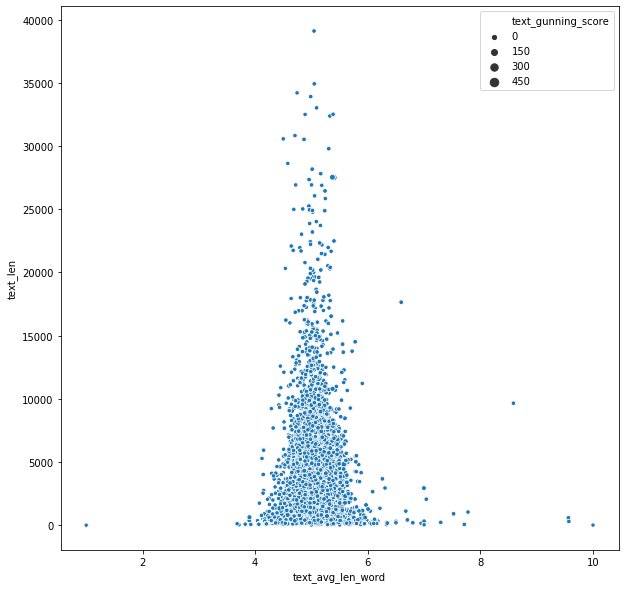

In [146]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=m_train, y="text_len", x="text_avg_len_word", size='text_gunning_score', ax=ax);

Niestety nie spowodowało to znacznego zwiększenia dokładności modelu, ale również go nie pogorszyła.

In [142]:
model4 = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_dict2, cv = 5, n_jobs=-1)
model4.fit(m_train, m_y_train)
model4.score(m_test, y_test)

0.6616161616161617

## Tokenizacja i Lemmatyzacja

Będziemy teraz operować na danych, które zostały stokenizowane, tzn.  słowa jak i znaki z tekstu zostały przeksztacone do listy. Również tzw. skrótowce czyli np. "Don't" zostały przekształcone na ["Do", "n't"].

Następnym krokiem była lemmatyzacja tzn. pozbywanie się słów pochodnych i pozostawianie słowa bazowego, np. z ciągu reducing, reduced, reduces, reduction pozostaję wyłącznie baza czyli reduce. Dodajmy odpowiednie kolumny

In [107]:
M_train = X_train.drop(indexes, axis=0)
M_y_train = y_train.drop(indexes, axis=0)
M_test = X_test.copy()

In [108]:
def lemmatization(df):
    doc = nlp(df)
    return ' '.join([token.lemma_ for token in doc])
M_train['text_lemma'] = M_train.text.apply(lambda row:lemmatization(row))
M_train['title_lemma'] = M_train.title.apply(lambda row:lemmatization(row))
M_test['text_lemma'] = M_test.text.apply(lambda row:lemmatization(row))
M_test['title_lemma'] = M_test.title.apply(lambda row:lemmatization(row))

Ponownie użyjemy tym razem algorytmu TF-IDF. Tym razem zauważmy jak zastosowanie lemmatyzacji znacząco zmniejszyło ilość nowych cech z 62 tysięcy do niepełnych 49 tysięcy.

In [109]:
vectorizer_lemma = TfidfVectorizer(stop_words='english')
M_train_text = vectorizer_lemma.fit_transform(M_train['text_lemma'])
M_test_text = vectorizer_lemma.transform(M_test['text_lemma'])
M_train_text.shape

(4728, 48755)

Otrzymujemy podobny wynik do tego uzyskanego jeszcze przed procesem lemmatyzacji, lecz plusem jest znaczna redukcja wymiaru macierzy wejściowej.

In [110]:
param_dict3 = {'C' : np.logspace(2, 5, 50)}

model5 = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_dict3, cv = 5, verbose=True, n_jobs=-1)
model5.fit(M_train_text, m_y_train)
print(model5.score(M_test_text, y_test))
model5.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   52.0s finished


0.9337121212121212


{'C': 232.99518105153717}

Wykorzystaliśmy powyżej TF-IDF wyłącznie dla kolumny tekstu, połączmy ją tym razem z kolumną tytułów. Jak widać ilość cech minimalnie wzrosła.

In [113]:
vectorizer_lemma = TfidfVectorizer(stop_words='english')
M_train_text_title = vectorizer_lemma.fit_transform(M_train['title_lemma'] + ' ' + M_train['text_lemma'])
M_test_text_title = vectorizer_lemma.transform(M_test['title_lemma'] + ' ' + M_test['text_lemma'])
M_train_text_title.shape

(4728, 49155)

Uzyskujemy jednak trochę wyższy wynik. Jak do tej pory jest to drugi najlepszy wynik bez wykorzystana kolumny 'Unnamed: 0'. Różni się od wyniku modelu1 (próbnego) w rzędzie tysięcznych posiadając przy tym prawie 15 tysięcy mniej kolumn.

In [114]:
param_dict4 = {'C' : np.logspace(2, 6, 100)}

model6 = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_dict4, cv = 5, verbose=True, n_jobs=-1)
model6.fit(M_train_text_title, m_y_train)
print(model6.score(M_test_text_title, y_test))
model6.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


0.9362373737373737


{'C': 4977.023564332114}

##  Zachowanie wyłącznie cech nienumerycznych

Jednym z procesów oczyszczających tekst jest usuniecię znaków numerycznych. Oprócz tego przy procesie lemmatyzacji uzyskujemy z zaimków osobowych 'I', 'You' itd. słowo '-PRON-', jego również się pozbędziemy.

In [115]:
def lemmatization_walpha(df):
    x = df.split(' ')
    return ' '.join([lemma for lemma in x if lemma.isalpha() or lemma == '-PRON-'])
M_train['text_lemma_walpha'] = M_train.text_lemma.apply(lambda row:lemmatization_walpha(row))
M_train['title_lemma_walpha'] = M_train.title_lemma.apply(lambda row:lemmatization_walpha(row))
M_test['text_lemma_walpha'] = M_test.text_lemma.apply(lambda row:lemmatization_walpha(row))
M_test['title_lemma_walpha'] = M_test.title_lemma.apply(lambda row:lemmatization_walpha(row))

In [116]:
vectorizer_lemma_2 = TfidfVectorizer(stop_words='english')
M_train_text_2 = vectorizer_lemma_2.fit_transform(M_train['text_lemma_walpha'])
M_test_text_2 = vectorizer_lemma_2.transform(M_test['text_lemma_walpha'])
M_train_text_2.shape

(4728, 45105)

Ponownie zredukowaliśmy wymiar o 4 tysiące kolumn. Zobaczmy jak to wpłynie na zachowanie modelu.

In [149]:
param_dict1 = {'C' : np.logspace(2, 5, 50)}

model7 = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_dict1, cv = 5, verbose=True, n_jobs=-1)
model7.fit(M_train_text_2, m_y_train)
print(model7.score(M_test_text_2, y_test))
model.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   46.3s finished


0.9318181818181818


{'C': 19.144819761699537, 'penalty': 'l2', 'solver': 'liblinear'}

Wynik jest gorszy, lecz w porównaniu z tym ile kolumn zostało odrzuconych nie wydaje się to znaczną różnicą. Tym razem wykorzystajmy również kolumne 'title_lemma'.

In [118]:
vectorizer_lemma_2 = TfidfVectorizer(stop_words='english')
M_train_text_title_2 = vectorizer_lemma_2.fit_transform(M_train['title_lemma_walpha'] + ' ' + M_train['text_lemma_walpha'])
M_test_text_title_2 = vectorizer_lemma_2.transform(M_test['title_lemma_walpha'] + ' ' + M_test['text_lemma_walpha'])
M_train_text_title_2.shape

(4728, 45488)

Niestety jednak tym razem ta operacja pogorszyła wynik.

In [119]:
model8 = GridSearchCV(LogisticRegression(random_state=42), param_grid=param_dict4, cv = 5, verbose=True, n_jobs=-1)
model8.fit(M_train_text_title_2, m_y_train)
model8.score(M_test_text_title_2, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


0.9292929292929293

##  Podsumowanie

Jak widać do tej pory najlepiej sprawował się model1 z wynikiem accuracy $\approx$ 94%. Przypomnijmy, że skorzystaliśmy tu z algorytmu TF-IDF na kolumnie tekstu. Zobaczmy jak prezentują się inne metryki.

In [148]:
preds = model1.predict(X_test_tf_try)
print(classification_report(y_test_try, preds))

              precision    recall  f1-score   support

        FAKE       0.93      0.95      0.94       794
        REAL       0.95      0.92      0.94       790

    accuracy                           0.94      1584
   macro avg       0.94      0.94      0.94      1584
weighted avg       0.94      0.94      0.94      1584



Jak widać pozotałe metryki są również w normie, a nawet są większe od dokładności. Zestawiając wyniki z drugim co do dokładności modelem (model6), gdzie użyto tokenizacji, lemmatyzacji i TF-IDF wyniki precision i recall są bardzo podobne. Warto jednak zwrócić uwagę na znaczną redukcję wymiarowości. 

In [147]:
preds = model6.predict(M_test_text_title)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.94       794
        REAL       0.94      0.93      0.94       790

    accuracy                           0.94      1584
   macro avg       0.94      0.94      0.94      1584
weighted avg       0.94      0.94      0.94      1584



Podsumowując, gdybyśmy dysponowali wyłącznie tekstem jak i tytułem, to nasz model prezentowałby się jak jeden z powyżej. Wybór odpowiedniego zależałby pewnie od aktualnych potrzeb. Możliwe, że komuś bardziej by zależało na scoringu, a komuś innemu natomiast na optymalizacji pamięci i złożoności obliczeniowej. Oba modele moim zdaniem uzyskały wysoki wynik, zwłaszcza przy takim nakładzie pracy włożonym w ich zaprogramowanie. Myślę, że powyższe algorytmy sprawdziłyby się lepiej w rozpoznaniu oszustwa niż człowiek, a przede wszystkim zautomatyzowałyby ten proces. Gdybyśmy dodatkowo dysponowali identyfikatorem danym w zbiorze danych, to dużo mniejszym kosztem jesteśmy w 100% podać czy dana wiadomość jest lub nie jest fałszywa.